<a href="https://www.kaggle.com/code/faizanaliabdulali/skeleton-matching?scriptVersionId=182994840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [2]:
!pip install rembg==2.0.56 -q

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rembg import new_session, remove
from sklearn.metrics.pairwise import cosine_similarity

## Image Pipeline

In [4]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, cropped_feature=None, key_contour=None):
        self.rgb_img = rgb_img                 # Original Img (RGB)
        self.mask_img = mask_img               # Orignal Img Mask (Binary)
        self.cropped_mask = cropped_mask       # Cropped Mask (Rotated + Binary)
        self.cropped_feature = cropped_feature # Cropped Feature (Rotated + Grayscale)
        self.key_contour = key_contour         # Key Contour

def fix_image_size(image):
    PADDING = 12
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    dimension = max(original_height, original_width)

    # Create a blank canvas of the desired size
    canvas = np.zeros((dimension, dimension), dtype=np.uint8)

    # Calculate the offset to center the image on the canvas
    offset_x = (canvas.shape[1] - image.shape[1]) // 2
    offset_y = (canvas.shape[0] - image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+image.shape[0], offset_x:offset_x+image.shape[1]] = image

    return canvas


def resize_grayscale_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_grayscale_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    return canvas


def is_ellipse_center_below_lower_half(center, image_shape):
    center_x, center_y = center
    image_width, image_height = image_shape
    return True if (center_y > image_height / 2) else False


def get_rotation_angle(is_below, current_angle):
    new_angle = 0
    if current_angle < 90:
        new_angle = 90 + current_angle
    elif current_angle > 90 and current_angle < 180:
        new_angle = current_angle - 90
    
    return (new_angle + 180) if is_below else (new_angle + 180)

def image_processing_pipeline(image_path):
    # 1. Read img as RGB
    rgb_img = np.array(image_path)

    # 2. Convert RGB to Grayscale and create an empty img of same dimension
    grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    empty_img = np.zeros_like(grayscale_img, dtype=np.uint8)

    # 3. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)

    # 4. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]

    # 6. Extract and paste only region of interest to grayscale image
    thickness = int((rgb_img.shape[0] + rgb_img.shape[1]) / 200)
    cv2.drawContours(empty_img, contours, -1, (255), thickness=thickness)
    cropped_feature = cv2.bitwise_and(grayscale_img, grayscale_img, mask=empty_img)
    
    # 7. Make model object
    img_model = ImageModel(rgb_img=np.array(rgb_img),
                           mask_img=mask_img,
                           cropped_mask=cropped_mask, # Useless
                           cropped_feature=cropped_feature, # Useless right now
                           key_contour=contours[0])
    
    # 8. Rotate key inside the image by fitting ellipse
    ellipse = cv2.fitEllipse(img_model.key_contour)
    center, axis_lengths, current_angle = ellipse
    is_below = is_ellipse_center_below_lower_half(center, img_model.mask_img.shape)
    rotation_angle = get_rotation_angle(is_below, current_angle)

    # 9. Resize mask and grayscale image before applying rotation
    resized_binary_image = fix_image_size(img_model.mask_img)
    resized_grayscale_image = fix_image_size(img_model.cropped_feature)

    # 10. Apply rotation
    center = (resized_binary_image.shape[1] // 2, resized_binary_image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    rotated_binary_image = cv2.warpAffine(resized_binary_image, rot_mat, resized_binary_image.shape[1::-1])
    rotated_grayscale_image = cv2.warpAffine(resized_grayscale_image, rot_mat, resized_grayscale_image.shape[1::-1])

    # 11. Cropped the rotated masked img
    contours, _ = cv2.findContours(rotated_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    rotated_binary_image = rotated_binary_image[y:y+h, x:x+w]
    rotated_grayscale_image = rotated_grayscale_image[y:y+h, x:x+w]

    # 12. Updated cropped masked
    img_model.cropped_mask = rotated_binary_image
    img_model.cropped_feature = rotated_grayscale_image
    
    # 13. Resized cropped feature t0 256x256
    rezised_feature = resize_grayscale_image_to_256x256(img_model.cropped_feature)
    
    _, binarized = cv2.threshold(rezised_feature, 1, 255, cv2.THRESH_BINARY)
    
    return binarized

def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def plt_contour(contour):
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Create an empty black image with dimensions based on the bounding box
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Draw the contour on the black image with the contour shifted to the top-left corner of the bounding box
    shifted_contour = contour - np.array([x, y])
    contour_image = cv2.drawContours(blank_image, [shifted_contour], -1, (0, 0, 255), thickness=cv2.FILLED)
    
    plt_img(contour_image)
    

def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

## Loading and Processing

In [5]:
filepaths, images = [], []
BASE_PATH = '/kaggle/input/key-images/'

for filename in os.listdir(BASE_PATH):
    if filename[0].isdigit():
        path = os.path.join(BASE_PATH, filename)
        filepaths.append(path)
        
filepaths.sort()
filepaths = filepaths[9:]

for filepath in filepaths:
    images.append(cv2.imread(filepath))

100%|████████████████████████████████████████| 179M/179M [00:00<00:00, 119GB/s]


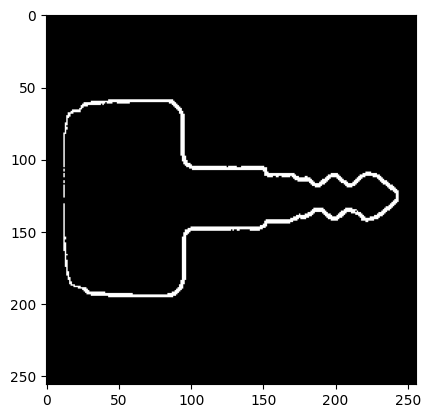

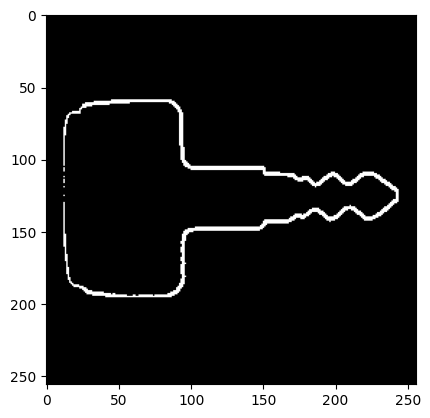

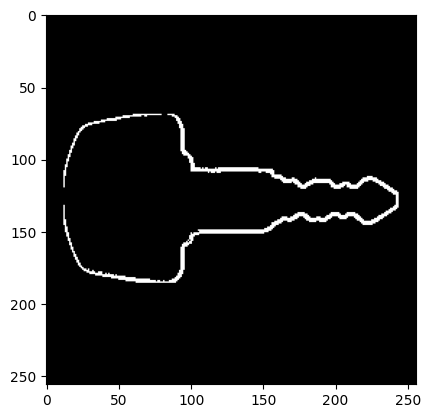

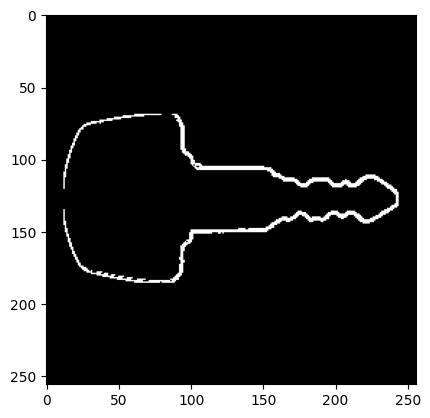

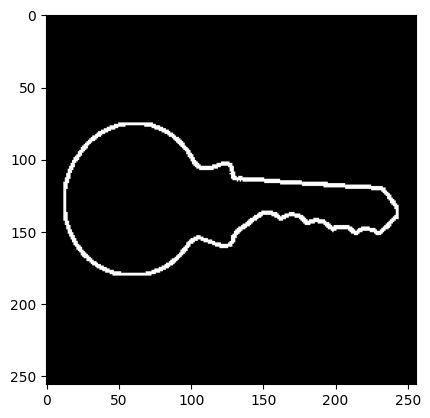

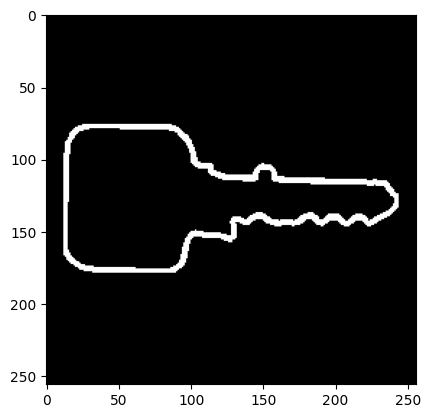

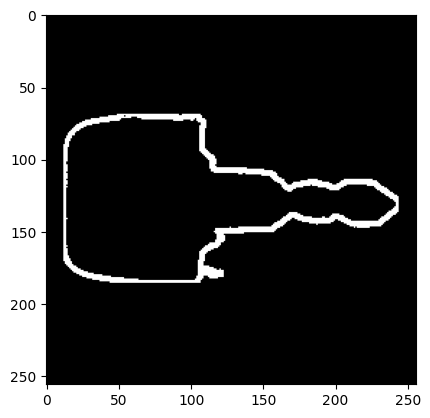

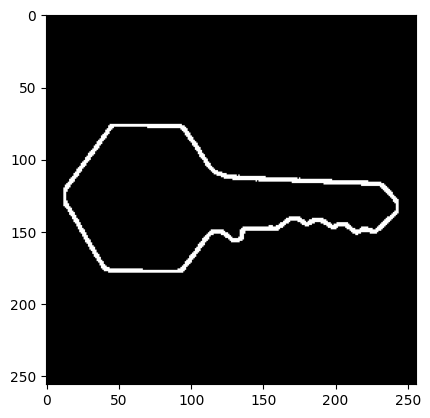

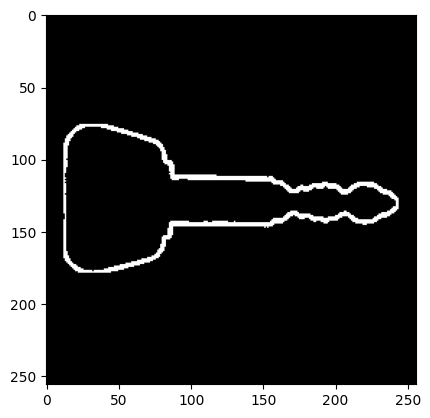

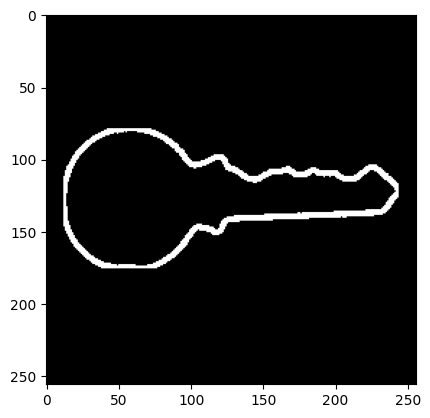

In [6]:
skeletons = []

for image in images:
    skeleton = image_processing_pipeline(image)
    plt_img(skeleton, cmap="gray")
    skeletons.append(skeleton)

## Cosine Similarity

In [35]:
def plot_cosine_similarity_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            flat_img1 = images_data[i].flatten().reshape(1, -1)
            flat_img2 = images_data[j].flatten().reshape(1, -1)

            cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]

            confusion_matrix[i, j] = round(cosine_sim, 4)

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_cosine_similarity_score(skeletons, indexes)

,1a.jpeg,1b.jpeg,2a.jpeg,2b.jpeg,3.jpeg,4.jpeg,5.jpg,7.jpg,8.jpg,9.jpg
1a.jpeg,1.0000,0.8534,0.2787,0.3649,0.1086,0.2535,0.2107,0.1220,0.1435,0.2189
1b.jpeg,0.8534,1.0000,0.2707,0.3474,0.1045,0.2303,0.2140,0.1180,0.1238,0.2344
2a.jpeg,0.2787,0.2707,1.0000,0.7790,0.1787,0.3545,0.4166,0.1964,0.2049,0.1686
2b.jpeg,0.3649,0.3474,0.7790,1.0000,0.1745,0.3482,0.3524,0.1835,0.1720,0.1928
3.jpeg,0.1086,0.1045,0.1787,0.1745,1.0000,0.2842,0.2014,0.3016,0.2155,0.2626
4.jpeg,0.2535,0.2303,0.3545,0.3482,0.2842,1.0000,0.3250,0.3972,0.3615,0.2287
5.jpg,0.2107,0.2140,0.4166,0.3524,0.2014,0.3250,1.0000,0.2424,0.3144,0.1373
7.jpg,0.1220,0.1180,0.1964,0.1835,0.3016,0.3972,0.2424,1.0000,0.1751,0.1080
8.jpg,0.1435,0.1238,0.2049,0.1720,0.2155,0.3615,0.3144,0.1751,1.0000,0.1728
9.jpg,0.2189,0.2344,0.1686,0.1928,0.2626,0.2287,0.1373,0.1080,0.1728,1.0000


## Hu Moments

In [36]:
def plot_hu_moments_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            
             # Calculate moments
            moments1 = cv2.moments(images_data[i])
            moments2 = cv2.moments(images_data[j])

            # Calculate Hu moments
            huMoments1 = cv2.HuMoments(moments1).flatten()
            huMoments2 = cv2.HuMoments(moments2).flatten()

            # Compare Hu moments using Euclidean distance
            distance = np.linalg.norm(huMoments1 - huMoments2)

            confusion_matrix[i, j] = round(1 - distance, 4)

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_hu_moments_score(skeletons, indexes)

,1a.jpeg,1b.jpeg,2a.jpeg,2b.jpeg,3.jpeg,4.jpeg,5.jpg,7.jpg,8.jpg,9.jpg
1a.jpeg,1.0000,0.9999,0.9996,0.9998,0.9988,0.9950,0.9952,0.9985,0.9972,0.9956
1b.jpeg,0.9999,1.0000,0.9997,0.9997,0.9989,0.9951,0.9953,0.9986,0.9973,0.9957
2a.jpeg,0.9996,0.9997,1.0000,0.9994,0.9992,0.9954,0.9956,0.9988,0.9976,0.9960
2b.jpeg,0.9998,0.9997,0.9994,1.0000,0.9986,0.9948,0.9951,0.9983,0.9970,0.9954
3.jpeg,0.9988,0.9989,0.9992,0.9986,1.0000,0.9962,0.9964,0.9997,0.9984,0.9968
4.jpeg,0.9950,0.9951,0.9954,0.9948,0.9962,1.0000,0.9998,0.9965,0.9978,0.9994
5.jpg,0.9952,0.9953,0.9956,0.9951,0.9964,0.9998,1.0000,0.9968,0.9980,0.9997
7.jpg,0.9985,0.9986,0.9988,0.9983,0.9997,0.9965,0.9968,1.0000,0.9988,0.9971
8.jpg,0.9972,0.9973,0.9976,0.9970,0.9984,0.9978,0.9980,0.9988,1.0000,0.9984
9.jpg,0.9956,0.9957,0.9960,0.9954,0.9968,0.9994,0.9997,0.9971,0.9984,1.0000


## Cosine Similarity Stress Testing

In [37]:
import math
import random

def random_rotate_image(image, rand_range):
    height, width = image.shape[:2]

    # Generate a random rotation angle between -30 and 30 degrees
    angle = random.uniform(-rand_range, rand_range)

    # Calculate the rotation matrix
    center = (width / 2, height / 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate the sine and cosine of the rotation angle
    cos_angle = abs(rot_matrix[0, 0])
    sin_angle = abs(rot_matrix[0, 1])

    # Compute the new bounding box dimensions
    new_width = int((height * sin_angle) + (width * cos_angle))
    new_height = int((height * cos_angle) + (width * sin_angle))

    # Adjust the rotation matrix to take into account the translation
    rot_matrix[0, 2] += (new_width / 2) - center[0]
    rot_matrix[1, 2] += (new_height / 2) - center[1]

    # Perform the rotation
    rotated_img = cv2.warpAffine(image, rot_matrix, (new_width, new_height))

    # Calculate the coordinates for cropping to the original size
    x = (new_width - width) // 2
    y = (new_height - height) // 2
    cropped_img = rotated_img[y:y + height, x:x + width]

    # Save the output image
    return cropped_img

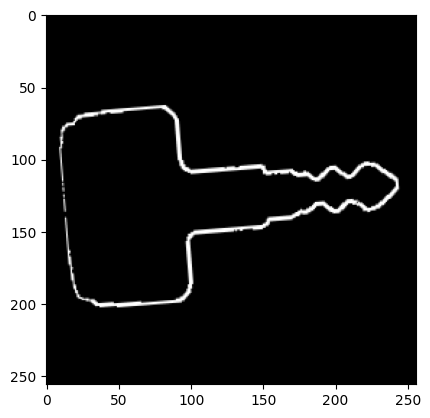

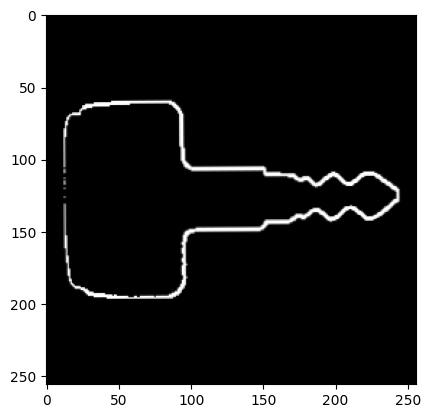

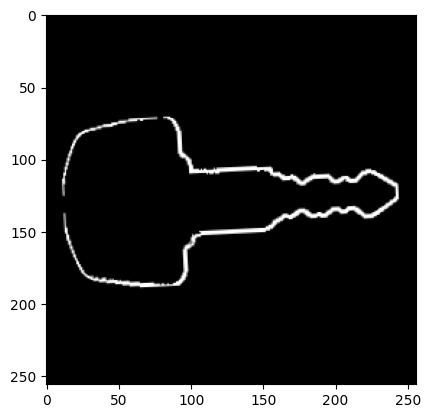

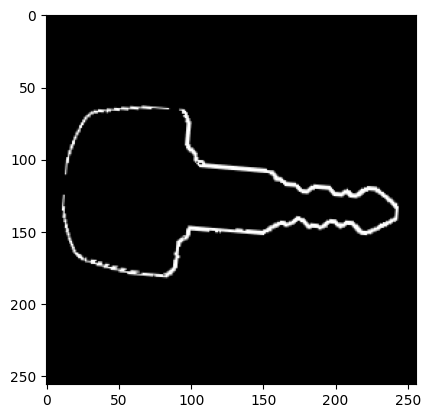

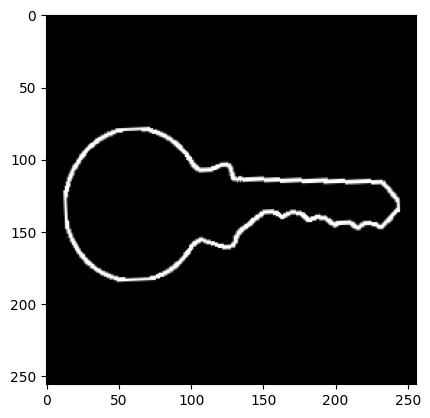

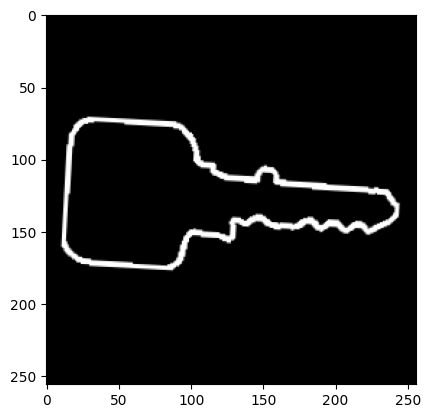

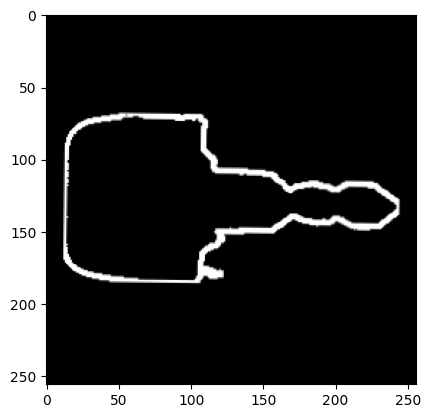

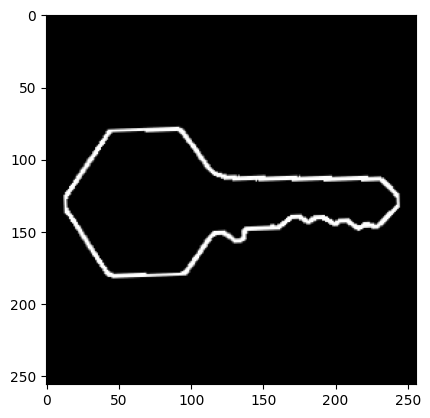

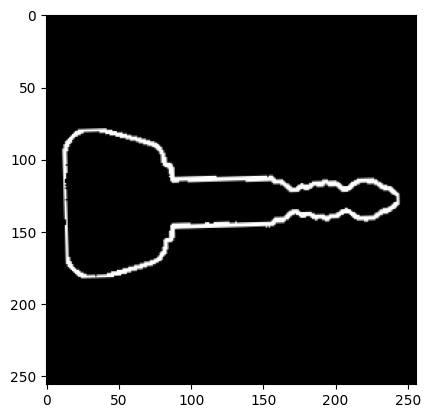

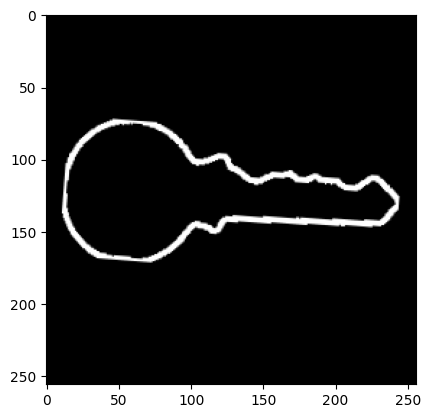

In [38]:
skewed_images = []

for image in skeletons:
    skewed = random_rotate_image(image, 5)
    skewed_images.append(skewed)
    plt_img(skewed, cmap="gray")

In [39]:
def plot_skewed_cosine_similarity_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            flat_img1 = images_data[i].flatten().reshape(1, -1)
            flat_img2 = images_data[j].flatten().reshape(1, -1)

            cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]

            confusion_matrix[i, j] = round(cosine_sim, 4)

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_cosine_similarity_score(skewed_images, indexes)

,1a.jpeg,1b.jpeg,2a.jpeg,2b.jpeg,3.jpeg,4.jpeg,5.jpg,7.jpg,8.jpg,9.jpg
1a.jpeg,1.0000,0.2314,0.2901,0.1576,0.1015,0.0955,0.1273,0.1012,0.0821,0.1159
1b.jpeg,0.2314,1.0000,0.4008,0.1948,0.1522,0.1397,0.2094,0.1792,0.1930,0.2010
2a.jpeg,0.2901,0.4008,1.0000,0.1754,0.1871,0.1520,0.2108,0.2037,0.1654,0.1898
2b.jpeg,0.1576,0.1948,0.1754,1.0000,0.1757,0.3938,0.3122,0.1850,0.1030,0.2019
3.jpeg,0.1015,0.1522,0.1871,0.1757,1.0000,0.2472,0.2449,0.3684,0.2400,0.3036
4.jpeg,0.0955,0.1397,0.1520,0.3938,0.2472,1.0000,0.3745,0.2475,0.2231,0.3007
5.jpg,0.1273,0.2094,0.2108,0.3122,0.2449,0.3745,1.0000,0.2242,0.2312,0.2423
7.jpg,0.1012,0.1792,0.2037,0.1850,0.3684,0.2475,0.2242,1.0000,0.1891,0.3161
8.jpg,0.0821,0.1930,0.1654,0.1030,0.2400,0.2231,0.2312,0.1891,1.0000,0.2466
9.jpg,0.1159,0.2010,0.1898,0.2019,0.3036,0.3007,0.2423,0.3161,0.2466,1.0000


## SIFT

In [52]:
def plot_SIFT_score(images_data, index_array):
    sift = cv2.SIFT_create()
    search_params = dict(checks=40)
    index_params = dict(algorithm=1, trees=5)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    MATCH_RATIO = 0.75
    all_keypoints = []
    all_descriptors = []

    for image in images_data:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        all_keypoints.append(keypoints), all_descriptors.append(descriptors)
    
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            matches = matcher.knnMatch(all_descriptors[i], all_descriptors[j], k=2)
            
            good_matches = []
            for m, n in matches:
                if m.distance < MATCH_RATIO * n.distance:
                    good_matches.append(m)

#             confusion_matrix[i, j] = len(matches) / min(
#                 len(all_descriptors[i]), 
#                 len(all_descriptors[j]),
#             )
            
            confusion_matrix[i, j] = len(good_matches) / len(all_descriptors[i])

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_SIFT_score(skeletons, indexes)

,1a.jpeg,1b.jpeg,2a.jpeg,2b.jpeg,3.jpeg,4.jpeg,5.jpg,7.jpg,8.jpg,9.jpg
1a.jpeg,1.000000,0.446154,0.230769,0.323077,0.169231,0.276923,0.169231,0.215385,0.169231,0.230769
1b.jpeg,0.400000,1.000000,0.280000,0.320000,0.200000,0.300000,0.240000,0.300000,0.300000,0.400000
2a.jpeg,0.175676,0.337838,1.000000,0.351351,0.175676,0.202703,0.283784,0.202703,0.135135,0.270270
2b.jpeg,0.261538,0.230769,0.246154,1.000000,0.138462,0.230769,0.276923,0.123077,0.200000,0.307692
3.jpeg,0.232877,0.342466,0.328767,0.232877,1.000000,0.328767,0.260274,0.452055,0.109589,0.315068
4.jpeg,0.081081,0.148649,0.297297,0.256757,0.243243,1.000000,0.229730,0.148649,0.472973,0.337838
5.jpg,0.133333,0.300000,0.350000,0.283333,0.216667,0.200000,1.000000,0.150000,0.166667,0.366667
7.jpg,0.184783,0.239130,0.163043,0.173913,0.206522,0.152174,0.315217,0.956522,0.217391,0.239130
8.jpg,0.250000,0.250000,0.250000,0.133333,0.116667,0.216667,0.250000,0.216667,1.000000,0.283333
9.jpg,0.179487,0.384615,0.358974,0.358974,0.384615,0.358974,0.333333,0.384615,0.358974,1.000000
